In [1]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel, AutoTokenizer
from multilingual_clip import pt_multilingual_clip
from PIL import Image
import os
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import tarfile

def uncompress_folders(folder):
    tars = os.listdir(folder)
    for i in tqdm(range(len(tars))):
        tar = tars[i]
        subfolder_name = os.path.join(folder, tar.split('.')[0])
        with tarfile.open(os.path.join(folder, tar)) as tar_file:
            tar_file.extractall(subfolder_name)

def index_image_paths(folder):
    image_paths = []
    for synset in os.listdir(folder):
        subfolder = os.path.join(folder, synset)
        if os.path.isdir(subfolder):
            for image_name in os.listdir(subfolder):
                image_paths.append(os.path.join(subfolder, image_name))

    return np.array(image_paths)

def index_image_paths_simple(folder):
    return np.array([f"{folder}\\{image}" for image in os.listdir(folder)])

def get_images_batch(image_paths, start, end):
    batch = []
    for path in image_paths[start:end]:
        batch.append(Image.open(path))
    return batch

def close_batch(batch):
    for image in batch:
        image.close()
    
def save_object(object, filename):
    with open(filename, "wb") as object_file:
        pickle.dump(object, object_file)
    
def read_object(filename):
    with open(filename, 'rb') as object_file:
        return pickle.load(object_file)

SRC_DIR = r"..\Django\ground_truth_videography_project"

In [ ]:
uncompress_folders(os.path.join(SRC_DIR, "imagenet-1k"))

In [4]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (manager-core).
Your token has been saved to C:\Users\jovin\.huggingface\token
Login successful


In [5]:
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
multilingual_model_id = "M-CLIP/XLM-Roberta-Large-Vit-B-32"
print(device)
print(torch.cuda.get_device_name(0))

tokeniser = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

# auto_tokeniser = AutoTokenizer.from_pretrained(multilingual_model_id)
# multilingual_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(multilingual_model_id)

# image_paths = index_image_paths("imagenet-1k")
# print(len(image_paths))

# img_matrix_file = "videography_pipeline\\image_vectors\\imagenet-1k-vecs.npy"

cuda
NVIDIA GeForce GTX 1650


OSError: [Errno 22] Invalid argument: 'C:\\Users\\jovin/.cache\\huggingface\\hub\\models--openai--clip-vit-base-patch32\\snapshots\\e6a30b603a447e251fdaca1c3056b2a16cdfebeb\\pytorch_model.bin'

In [ ]:
batch_size = 32
img_vectors = np.load(img_matrix_file) if os.path.exists(img_matrix_file) else None

start = 0 if img_vectors is None else img_vectors.shape[0]

print(f"Starting from {start}...")

for i in tqdm(range(start, len(image_paths), batch_size)):
    try:
        images_batch = get_images_batch(image_paths, i, i+batch_size)

        batch = processor(
            text=None,
            images=images_batch,
            return_tensors="pt",
            padding=True
        )["pixel_values"].to(device)

        close_batch(images_batch)

        batch_embeddings = model.get_image_features(pixel_values=batch).squeeze(0)
        batch_embeddings = batch_embeddings.cpu().detach().numpy()

        img_vectors = np.concatenate((img_vectors, batch_embeddings)) if img_vectors is not None else batch_embeddings

        if (i//batch_size) % 1000 == 0:
            print(i//batch_size)
            np.save(img_matrix_file, img_vectors)
    except Exception as ex:
        print(f"\u001b[31m{type(ex).__name__}: {ex.args}\u001b[0m")

np.save(img_matrix_file, img_vectors)
img_vectors.min(), img_vectors.max()

In [3]:
filter = [516621, 653283, 589736, 630260, 590689, 516333, 701639, 538449, 558009, 1017551, 590174, 558027, 590157, 559003, 604023, 572346, 661681, 993150, 1018475, 792565, 1054980, 993647, 515930, 1279994, 1122816, 1122783, 1122318, 559453, 1122669, 1017594, 1122462, 558741, 558533, 559600, 1121668, 1121871, 1122352, 558838, 559166, 559573, 1122659, 1122602, 1147593, 590688, 766038, 589621, ]

image_paths = np.delete(index_image_paths(os.path.join(SRC_DIR, "imagenet-1k")), filter)

# img_vectors = np.load("videography_pipeline\\image_vectors\\imagenet-1k-vecs.npy")
img_vectors= np.load(os.path.join(SRC_DIR, "utilities\\image_vectors\\imagenet-1k-vecs-FILTERED.npy"))
print(img_vectors.shape)

img_vectors.min(), img_vectors.max()

(1281121, 512)


(-10.823898, 4.7323346)

(1, 1281121)
imagenet-1k\n03874599\n03874599_6903.JPEG (892185): 29.72783851623535


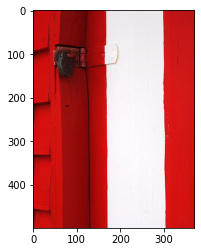

imagenet-1k\n04590129\n04590129_986.JPEG (1159830): 29.2308292388916


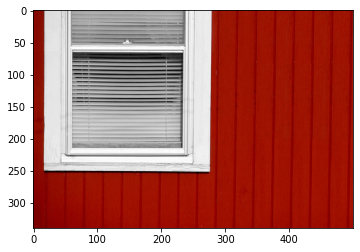

imagenet-1k\n04515003\n04515003_1613.JPEG (1128200): 28.802488327026367


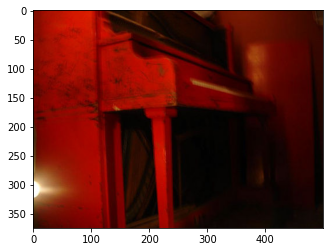

imagenet-1k\n03930313\n03930313_20282.JPEG (918461): 28.123655319213867


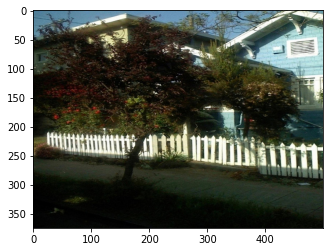

imagenet-1k\n02793495\n02793495_10539.JPEG (545591): 27.939876556396484


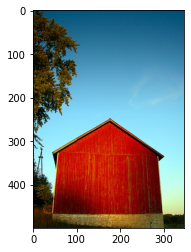

In [5]:
prompt = "यह घर बहुत लाल है"

inputs = tokeniser(prompt, return_tensors="pt").to(device)
text_emb = model.get_text_features(**inputs)

text_emb = text_emb.cpu().detach().numpy()

# text_emb = multilingual_model.forward(prompt, auto_tokeniser).to(device)
# text_emb = text_emb.cpu().detach().numpy()

# scores = np.dot(text_emb, img_vectors_filtered.T)
scores = np.dot(text_emb, img_vectors.T)
print(scores.shape)

best = np.argsort(-scores[0])[:5]
for i in best:
    print(f"{image_paths[i]} ({i}): {scores[0][i]}")
    # with Image.open(image_paths_filtered[i]) as image:
    with Image.open(image_paths[i]) as image:
        plt.imshow(image, cmap='gray')
        plt.show()

# Filtering

In [6]:
filter = [516621, 653283, 589736, 630260, 590689, 516333, 701639, 538449, 558009, 1017551, 590174, 558027, 590157, 559003, 604023, 572346, 661681, 993150, 1018475, 792565, 1054980, 993647, 515930, 1279994, 1122816, 1122783, 1122318, 559453, 1122669, 1017594, 1122462, 558741, 558533, 559600, 1121668, 1121871, 1122352, 558838, 559166, 559573, 1122659, 1122602, 1147593, 590688, 766038, 589621, ]

image_paths_filtered = np.delete(image_paths, filter)
img_vectors_filtered = np.delete(img_vectors, filter, axis=0)

# for i in image_paths[filter]:
#     with Image.open(i) as image:
#         plt.imshow(image, cmap='gray')
#         plt.show()

# img_vectors = np.delete(img_vectors, filter, axis=0)
# print(f"{len(image_paths)} - {len(filter)} = {len(image_paths) - len(filter)} | {img_vectors.shape}")

1281167
1281167 - 26 = 1281141 | (1281141, 512)


In [ ]:
for i, image in enumerate(image_paths[1122793-len(filter):1122793+len(filter)]):
    with Image.open(image) as image:
        print(i + 1122793-len(filter))
        plt.imshow(image, cmap='gray')
        plt.show()

# Resolution Experiment

In [4]:
import json

resolutions = []
for i in tqdm(range(0, len(image_paths), 1024)):
    batch = get_images_batch(image_paths, i, i+1024)
    resolutions += [image.size for image in batch]
    close_batch(batch)

print(len(resolutions))
print(max(resolutions))

with open('resolutions.json', 'w') as resolutions_json:
    json.dump(resolutions, resolutions_json)

100%|██████████| 1252/1252 [21:11<00:00,  1.02s/it]


1281121
(9331, 2105)


In [25]:
print(f"Mean Resolution: {tuple(np.mean(resolutions, axis=0))} | std={tuple(np.std(resolutions, axis=0))}")

Mean Resolution: (472.99183293381344, 405.50733459212677) | std=(208.06318066381138, 178.74230665419847)


9019.566730591132
(9331, 2105)
..\Django\ground_truth_videography_project\imagenet-1k\n03933933\n03933933_10972.JPEG


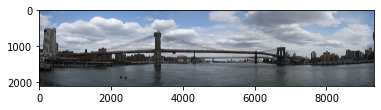

In [6]:
resolutions_mul = [width*height for width,height in resolutions]
distances = np.linalg.norm(np.array(resolutions) - np.mean(resolutions, axis=0), axis=1)
print(np.max(distances))

print(resolutions[np.argmax(distances)])
print(image_paths[np.argmax(distances)])
with Image.open(image_paths[np.argmax(distances)]) as bigboi:
    plt.imshow(bigboi)

# Ground Truth Loading

In [ ]:
gt = load_ground_truth(SRC_FOLDER, audio.filename)

# WITHIN FOR CHUNKS FOR LOOP
    chunk.selected_ids = np.where(np.isin(chunk.image_ids, gt["chunks"][chunk.index - 1]["selected_image_ids"]))[0].tolist()
    chunk.save()